Program Name: Jet_Length_Width_Determiner_KS-test_Draft1.py

Date: 6/14/2022

Creator: Sol Samuels

Description: 
 - This program intakes two jet related FITS files from ones device, specifically those named in the format \*\*/Group\*0.00_1.00_0.00\*.fits\* , and returns a KS-test graph comparing the two files normalized cumulative intensity values.
 - Draft 1. Not currently functional.
 - NOTE: This is version 1 of this program. Program is subject to be changed.
 
Variable Keywords:
 - cul = "cumulative"
 - slice = refers to rows or columns of fits image pixels
 - vals = "values"
 - norm = "normalized"

In [1]:
import astropy.io
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema


In [2]:
def kpc_convert(pixel_len, pixel_size):
    cm_len = pixel_len * pixel_size
    kpc_len = round((cm_len * 3.24077928967e-19) / 1e3, 4)
    return kpc_len

In [3]:
#This Function Takes FITS data and pixel size to display Jet Length Info
def jet_length(data, pixel_size):
    
    #Creates list of slice sums
    slice_vals = []
    for row in data:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
            
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
        
    x_vals_med = round(np.median(x_vals))
    x_vals_Q1 = round(np.median(x_vals[:x_vals_med]))
    x_vals_Q3 = round(np.median(x_vals[x_vals_med:]))
    
    
    smooth = gaussian_filter1d(norm_cul_vals_edit, 10)
    d1 = np.gradient(smooth)
    smooth_d1 = gaussian_filter1d(d1, 50)
    d2 = np.gradient(smooth_d1)
    smooth_d2 = gaussian_filter1d(d2, 100)
    
    # for local maxima
    maxima_d2 = argrelextrema(smooth_d2, np.greater)
    # for local minima
    minima_d2 = argrelextrema(smooth_d2, np.less)

    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    min_lst = []
    max_lst = []
    if len(maxima_d2) > 0:
        for element in maxima_d2:
            for index in element:
                try:
                    max_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
    if len(minima_d2) > 0:
        for element in minima_d2:
            for index in element:
                try:
                    min_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
    
    
    max_lst = sorted(max_lst)
    min_lst = sorted(min_lst)
    
    if (len(max_lst) + len(min_lst)) > 3:
        
        main_max = []
        main_min = []
        for point in max_lst:
            if point > x_vals_med and point < x_vals_Q3:
                main_max.append(point)
        for point in min_lst:
            if point > x_vals_Q1 and point < x_vals_med:
                main_min.append(point)
        
        
        slice_vals_edit = []
        flag = False
        for element in slice_vals:
            if flag is True:
                slice_vals_edit.append(element)
            if element != 0 and flag is False:
                flag = True
                slice_vals_edit.append(element)
        
        for i in range(max(main_min), min(main_max)):
            slice_vals_edit[i] = float(0)
            
        lobe_dist = min(main_max) - max(main_min)

        cul_vals = []
        movingsum = 0
        for element in slice_vals_edit:
            movingsum += element
            cul_vals.append(movingsum)

        #Normalizes the Cumulative Values and creates list
        max_val = cul_vals[-1]
        norm_cul_vals = []
        norm = 0
        for element in cul_vals:
            norm = element / max_val
            norm_cul_vals.append(norm)

        #Edits the Normalizes Values to Exclude zeros and repeating terms
        final_reached = False
        norm_cul_vals_edit = []
        for element in norm_cul_vals:
            if element != 0 and final_reached is False:
                norm_cul_vals_edit.append(element)
            if element == 1:
                final_reached = True

        x_vals = []
        for x in range(len(norm_cul_vals_edit)):
            d = kpc_convert(x, pixel_size)
            x_vals.append(d)

    
        #Determines and prints length of jet in pixels. Estimates to 0.98
        pixel_count = 0
        for element in norm_cul_vals_edit:
            if element >= 0.02 and element <= 0.98:
                pixel_count += 1

        #Converts pixel size to cm and prints
        jet_size_cm = pixel_size * pixel_count

        #Converts cm size to kpc and prints
        jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
        
        lobe_dist_cm = lobe_dist * pixel_size
        lobe_dist_kpc = round((lobe_dist_cm * 3.24077928967e-19) / 1e3, 4)
    
    return norm_cul_vals_edit

In [4]:
#This Function Takes FITS data, FITS image width and pixel size to display Jet Width Info
def jet_width(data, width, pixel_size):
    
    #Reorients data so rows become columns
    data_reorient = []
    for x in range(width):
        col_sub = []
        for row in data:
            col_sub.append(row[x])
        data_reorient.append(col_sub)
        
    #Creates list of slice sums
    slice_vals = []
    for row in data_reorient:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True

    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    return norm_cul_vals_edit
    

In [5]:
nu = [30.0, 74.0, 150.0, 315.0, 395.0, 460.0, 630.0, 730.0, 1400.0, 3000.0, 5000.0, 8000.0]
years = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 121.2, 256.1, 513.1, 773.1]

print("Possible Frequency Values: {}".format(nu))
freq_given = False
while freq_given is False:

    chosen_nu = input("Choose Frequency Value to Compare Against: ")

    try:
        chosen_nu = float(chosen_nu)
        if chosen_nu in nu:
            nu.remove(chosen_nu)
            freq_given = True
        else:
            print("Not a possible frequency value!")
    except ValueError:
        print("Input must be a float value")


removable_nu = [74.0, 315.0, 460.0, 730.0, 3000.0, 8000.0]
for value in removable_nu:
    try:
        nu.remove(value)
    except ValueError:
        p=0

Possible Frequency Values: [30.0, 74.0, 150.0, 315.0, 395.0, 460.0, 630.0, 730.0, 1400.0, 3000.0, 5000.0, 8000.0]


Choose Frequency Value to Compare Against:  395.0



JET LENGTH AND WIDTH DETERMINING PROGRAM:
____________________________________________________________________________________________________

TRYING YEAR: 1.0 Myr

Length KS-Test for 1.0 Myr: 



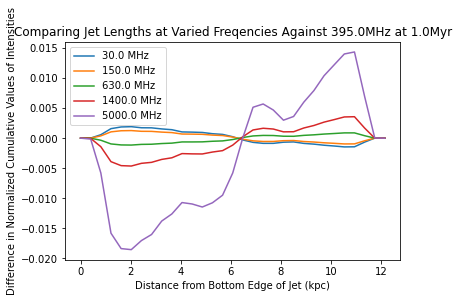


Width KS-Test for 1.0 Myr:



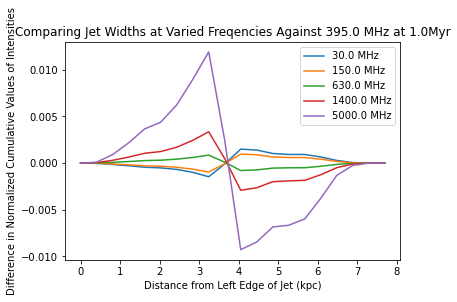


---------------------------------------------------------------------------

TRYING YEAR: 2.0 Myr

Length KS-Test for 2.0 Myr: 



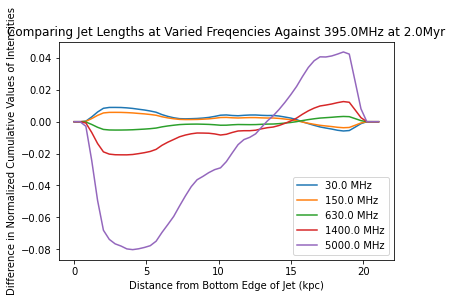


Width KS-Test for 2.0 Myr:



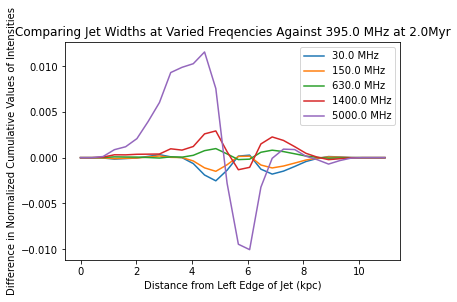


---------------------------------------------------------------------------

TRYING YEAR: 4.0 Myr

Length KS-Test for 4.0 Myr: 



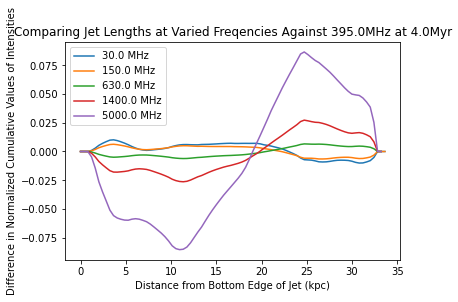


Width KS-Test for 4.0 Myr:



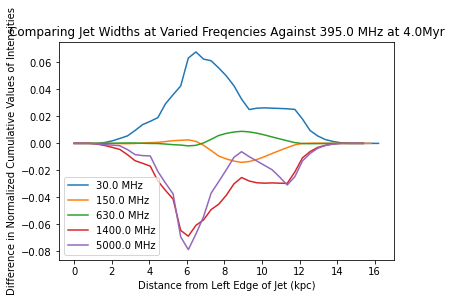


---------------------------------------------------------------------------

TRYING YEAR: 8.0 Myr

Length KS-Test for 8.0 Myr: 



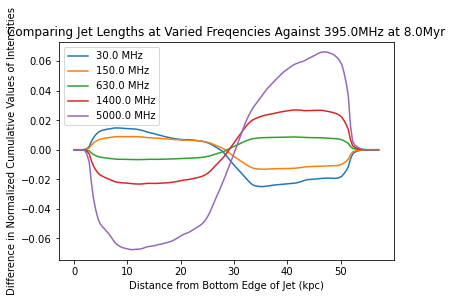


Width KS-Test for 8.0 Myr:



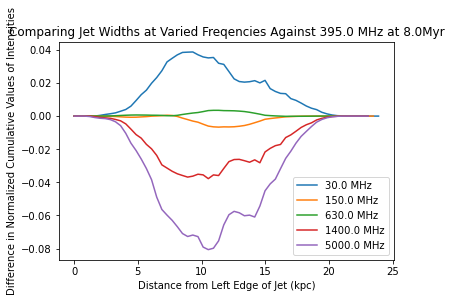


---------------------------------------------------------------------------

TRYING YEAR: 16.0 Myr

Length KS-Test for 16.0 Myr: 



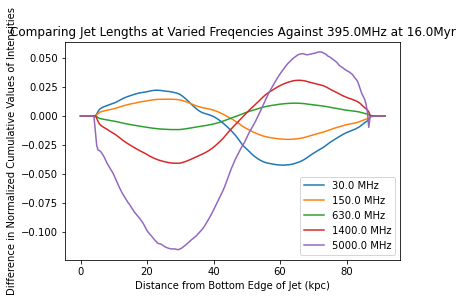


Width KS-Test for 16.0 Myr:



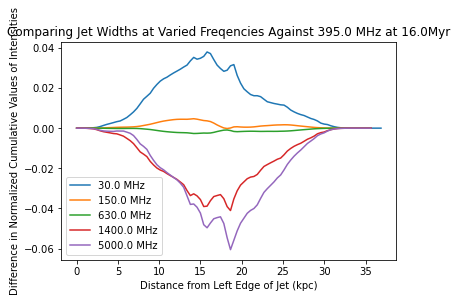


---------------------------------------------------------------------------

TRYING YEAR: 32.0 Myr

Length KS-Test for 32.0 Myr: 



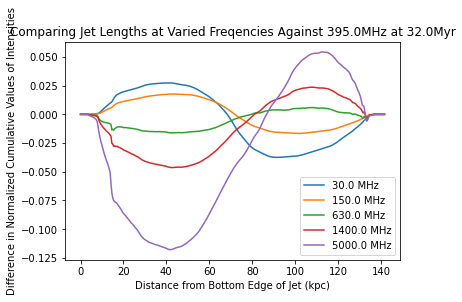


Width KS-Test for 32.0 Myr:



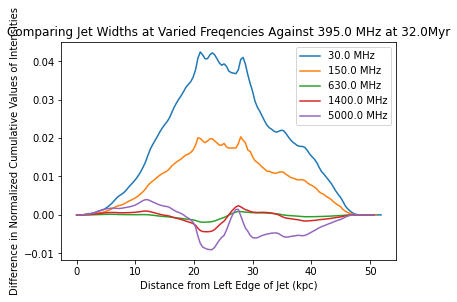


---------------------------------------------------------------------------

TRYING YEAR: 64.0 Myr

Length KS-Test for 64.0 Myr: 



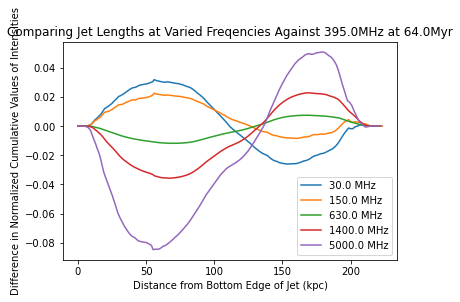


Width KS-Test for 64.0 Myr:



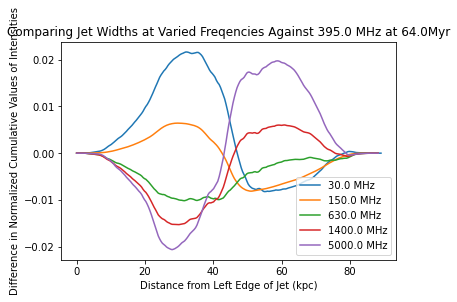


---------------------------------------------------------------------------

TRYING YEAR: 121.2 Myr

Length KS-Test for 121.2 Myr: 



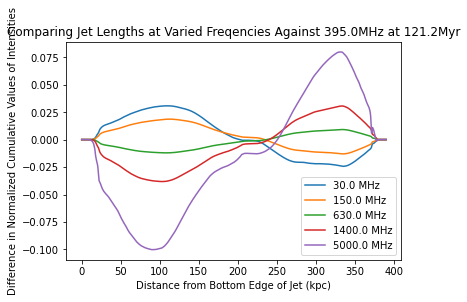


Width KS-Test for 121.2 Myr:



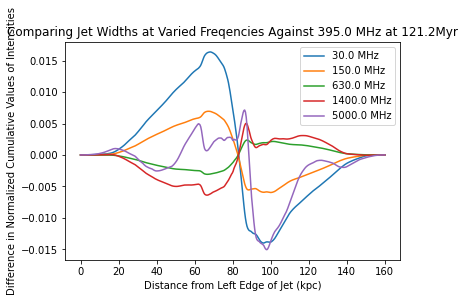


---------------------------------------------------------------------------

TRYING YEAR: 256.1 Myr

Length KS-Test for 256.1 Myr: 



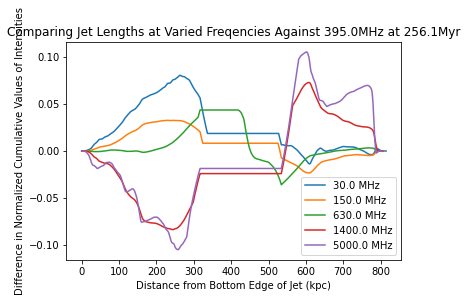


Width KS-Test for 256.1 Myr:



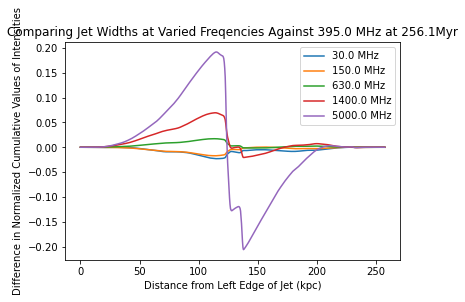


---------------------------------------------------------------------------

TRYING YEAR: 513.1 Myr

Length KS-Test for 513.1 Myr: 



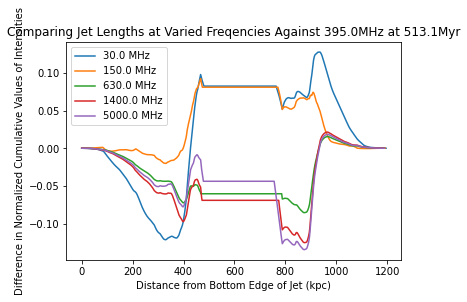


Width KS-Test for 513.1 Myr:



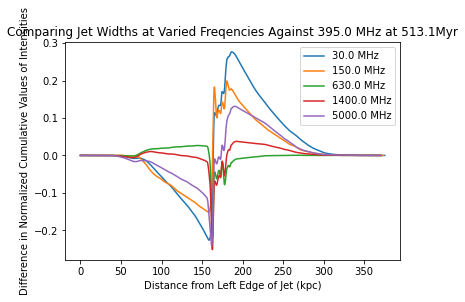


---------------------------------------------------------------------------

TRYING YEAR: 773.1 Myr

Length KS-Test for 773.1 Myr: 



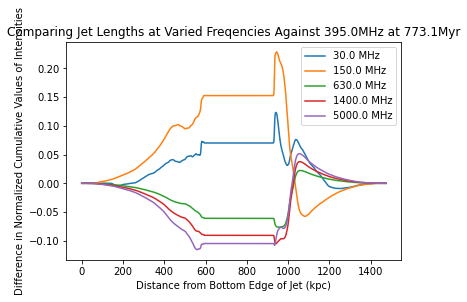


Width KS-Test for 773.1 Myr:



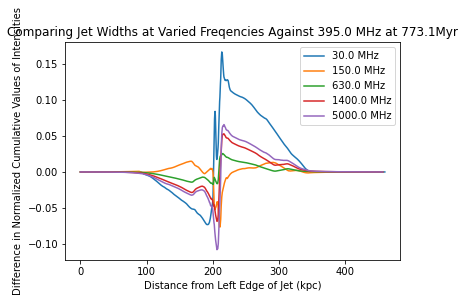


---------------------------------------------------------------------------



In [6]:
#Main Calling Block of Code

print("\nJET LENGTH AND WIDTH DETERMINING PROGRAM:")
print("{}\n".format("_"*100))

for year in years:
    print("TRYING YEAR: {} Myr".format(year))

    path = '**/Group*nu={}*0.00_1.00_0.00*_{}Myr.fits*'.format(chosen_nu, year)

    # Determines if there are any files in device
    total_files = len(glob.glob(path, recursive=True))

    if total_files > 0:
        file_count = 0
        for file in glob.glob(path, recursive=True):

            file_count += 1

            try:
                fits_image_hdul = fits.open(file)

                #Displays FITS Image title, time index, and pixel size
                sim_title = fits_image_hdul[0].header['OBJECT']
                sim_time = fits_image_hdul[0].header['TIME']
                pixel = fits_image_hdul[0].header['CDELT1']
                pixel_size = float(pixel[:-3])

                #Defines Data From FITS image and records image dimensions
                data =  fits_image_hdul[0].data
                length = len(data[0])
                width = len(data)


                jet_len = jet_length(data, pixel_size)
                x_vals = []
                kpc_vals = []
                for x in range(len(jet_len)):
                    cm = (pixel_size * x)
                    kpc = round((cm * 3.24077928967e-19) / 1e3, 4)
                    x_vals.append(x)
                    kpc_vals.append(kpc)


                jet_wid = jet_width(data, width, pixel_size)
                x2_vals = []
                kpc2_vals = []
                for x2 in range(len(jet_wid)):
                    cm = (pixel_size * x2)
                    kpc = round((cm * 3.24077928967e-19) / 1e3, 4)
                    x2_vals.append(x2)
                    kpc2_vals.append(kpc)

            except OSError:
                print("Error with file: {}".format(file))
                print("Empty or corrupt FITS file")

    else:
        print("ERROR: Could not find any necessary files on your device")
        print("Program intakes files of the name: {}".format(path))



    for value in nu:
        path = '**/Group*nu={}*0.00_1.00_0.00*_{}Myr.fits*'.format(value, year)

        # Determines if there are any files in device
        total_files = len(glob.glob(path, recursive=True))

        if total_files > 0:
            file_count = 0
            for file in glob.glob(path, recursive=True):

                file_count += 1

                try:
                    fits_image_hdul = fits.open(file)

                    #Displays FITS Image title, time index, and pixel size
                    sim_title = fits_image_hdul[0].header['OBJECT']
                    sim_time = fits_image_hdul[0].header['TIME']
                    pixel = fits_image_hdul[0].header['CDELT1']
                    pixel_size = float(pixel[:-3])

                    #Difines Data From FITS image and records image dimensions
                    data =  fits_image_hdul[0].data
                    length = len(data[0])
                    width = len(data)


                    jet_len_compare = jet_length(data, pixel_size)


                    kpc_vals_compare = []
                    x_vals_compare = []
                    for x in range(len(jet_len_compare)):
                            cm = (pixel_size * x)
                            kpc = round((cm * 3.24077928967e-19) / 1e3, 4)
                            x_vals_compare.append(x)
                            kpc_vals_compare.append(kpc)


                except OSError:
                    print("Error with file: {}".format(file))
                    print("Empty or corrupt FITS file")

        else:
            print("ERROR: Could not find any necessary files on your device")
            print("Program intakes files of the name: {}".format(path))

        x_vals_input = x_vals
        if len(x_vals_compare) > len(x_vals):
            x_vals_input = x_vals_compare

        length_difference = []
        for i in x_vals_input:
            try:
                diff = jet_len[i] - jet_len_compare[i]
                length_difference.append(diff)
            except IndexError:
                length_difference.append(0.0)

        kpc_val_input = kpc_vals
        if len(kpc_vals_compare) > len(kpc_vals):
            kpc_val_input = kpc_vals_compare

        plt.plot(kpc_val_input, length_difference, label = "{} MHz".format(str(value)))

    print("\nLength KS-Test for {} Myr: \n".format(year))
    plt.title("Comparing Jet Intensities at Varied Freqencies Against {}MHz at {}Myr".format(chosen_nu, year))
    plt.xlabel("Distance from Bottom Edge of Jet (kpc)")
    plt.ylabel("Difference in Normalized Cumulative Values of Intensities")
    plt.legend()
    plt.show()



    for value in nu:
        path = '**/Group*nu={}*0.00_1.00_0.00*_{}Myr.fits*'.format(value, year)

        # Determines if there are any files in device
        total_files = len(glob.glob(path, recursive=True))

        if total_files > 0:
            file_count = 0
            for file in glob.glob(path, recursive=True):

                file_count += 1

                try:
                    fits_image_hdul = fits.open(file)

                    #Displays FITS Image title, time index, and pixel size
                    sim_title = fits_image_hdul[0].header['OBJECT']
                    sim_time = fits_image_hdul[0].header['TIME']
                    pixel = fits_image_hdul[0].header['CDELT1']
                    pixel_size = float(pixel[:-3])

                    #Defines Data From FITS image and records image dimensions
                    data =  fits_image_hdul[0].data
                    length = len(data[0])
                    width = len(data)


                    jet_wid_compare = jet_width(data, width, pixel_size)

                    x2_vals_compare = []
                    kpc2_vals_compare = []
                    for x2 in range(len(jet_wid_compare)):
                        cm = (pixel_size * x2)
                        kpc = round((cm * 3.24077928967e-19) / 1e3, 4)
                        x2_vals_compare.append(x2)
                        kpc2_vals_compare.append(kpc)



                except OSError:
                    print("Error with file: {}".format(file))
                    print("Empty or corrupt FITS file")

        else:
            print("ERROR: Could not find any necessary files on your device")
            print("Program intakes files of the name: {}".format(path))

        x_vals_input = x2_vals
        if len(x2_vals_compare) > len(x2_vals):
            x_vals_input = x2_vals_compare

        width_difference = []
        for i in x_vals_input:
            try:
                diff = jet_wid[i] - jet_wid_compare[i]
                width_difference.append(diff)
            except IndexError:
                width_difference.append(0.0)

        kpc_val_input = kpc2_vals
        if len(kpc2_vals_compare) > len(kpc2_vals):
            kpc_val_input = kpc2_vals_compare
        plt.plot(kpc_val_input, width_difference, label = "{} MHz".format(str(value)))

    print("\nWidth KS-Test for {} Myr:\n".format(year))
    plt.title("Comparing Jet Intensities at Varied Freqencies Against {} MHz at {}Myr".format(chosen_nu, year))
    plt.xlabel("Distance from Left Edge of Jet (kpc)")
    plt.ylabel("Difference in Normalized Cumulative Values of Intensities")
    plt.legend()
    plt.show()
              
    print("\n{}\n".format("-"*75))